In [2]:
import pystan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.stats as stats
from multiprocessing import Pool
import sys

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Define some functions to implement the algorithm

In [72]:
Lprime, warmup, L, N = 250, 250, 2**7-1, 10000
def get_n_eff(fit, variables):
    '''
    annoying helper to find the neff from the stan summary
    '''
    summary_ = fit.summary()
    variables_updated = variables + [v+'[0]' for v in variables]
    neff = dict([(name, summary[-2]) for (name, summary) in zip(summary_['summary_rownames'], summary_['summary']) if name in variables_updated])
    for k,v in neff.items():
        if '[0]' in k:
            neff[k[:k.index('[0]')]] = neff.pop(k)
    return neff

def get_last_sample(la):
    last_samp = {}
    for k, val in la.items():
        if k != 'lp__':
             last_samp[k] = val[-1]
    return last_samp

def run_experiment_alg1(data_gen, model, variables):

    result = {}
    
    # draw a prior sample and simulated dataset
    exp_data = data_gen()
    
    # draw L posterior samples
    fit = model.sampling(data=exp_data, iter=warmup+L, warmup=warmup, chains=1)
    la = fit.extract(permuted=True)
    
    # for each variable follow Alg
    for k in variables:
        samples = la.get(k)
        theta_l = samples if len(samples.shape) == 1 else samples[0,:]
        rankf = np.sum(theta_l < exp_data[k])
        result[k] = rankf
    return result

def run_experiment_alg2(data_gen, model, variables):
    
    result = {}
    
    # draw a prior sample and simulated dataset
    exp_data = data_gen()
    
    # draw L posterior samples
    fit = model.sampling(data=exp_data, iter=warmup+Lprime, warmup=warmup, chains=1)
    la = fit.extract(permuted=True)
    init = [get_last_sample(la)]
    
    # get the effective sample sizes (comment this out if you want to run Alg1)
    neff = get_n_eff(fit, variables)
    for var in variables:
        if neff[var] < L:
            # carry on sampling by L' L/Neff samples
            new_num_samples = int(Lprime * L/neff[var])
            fit2 = model.sampling(data=exp_data, iter=new_num_samples+100, warmup=100, chains=1, init=init)
            la2 = fit2.extract(permuted=True)
            neff2 = get_n_eff(fit2, variables)
            # add the new samples to the stored data
            for k,v in la.items():
                la[k] = np.concatenate([v,la2[k]])
                if k in variables:
                    neff[k] += neff2[k]
                
    # for each variable follow Alg
    for k in variables:
        # uniformly thin the resulting states
        samples = la.get(k)
        length = np.max(samples.shape)
        indexes = list(range(0,length,length//L))[:L]
        #choose to execute Alg1 or Alg2
        #theta_l = samples[:L] if len(samples.shape) == 1 else samples[0,:L]
        theta_l = samples[indexes] if len(samples.shape) == 1 else samples[0,indexes]
        rankf = np.sum(theta_l < exp_data[k])
        result[k] = rankf
    return result

def algorithm(data_gen, experiment, variables):
    results_var = dict([(v, np.zeros(N, dtype=np.int16)) for v in variables])
    
    # using 8 processors
    pool = Pool(8)

    results = []
    for n in range(0,N):
        results.append(pool.apply_async(run_experiment_alg2, args=(data_gen, experiment, variables, )))

    for i,result in enumerate(results):
        res = result.get()
        for var in variables:
            results_var[var][i] = res[var]
    return results_var

# Linear Regression

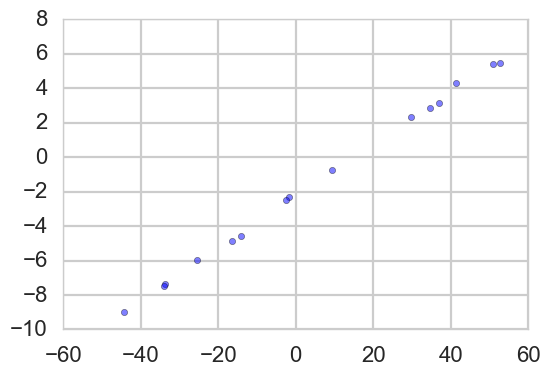

In [64]:
def generate_data1():
    N = 15
#     X = np.arange(-10,10,(10+10)/N)
    X = np.array(np.random.uniform(-10,10, size=N))
    
    alpha = np.random.normal(0, 10)
    beta = np.random.normal(0, 10)
    
    Y = np.zeros(N)
    for i in range(N):
        Y[i] = np.random.normal(alpha + X[i]*beta, 1.2)
    return {'alpha': alpha, 'beta': beta, 'X': X, 'y': Y, 'N': N}

exp1_data = generate_data1()

plt.scatter(exp1_data['y'],exp1_data['X'], alpha=0.5)
plt.show()

In [65]:
exp1_code = '''
data {
    int<lower=1> N;
    vector[N] X;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
}

model {
    alpha ~ normal(0,10);
    beta ~ normal(0,10);
    y ~ normal(alpha + X*beta, 1.2);
}
'''
# Run only to compile:
# exp1 = pystan.StanModel(model_code=exp1_code)
# exp_tight_prior = pystan.StanModel(model_code=exp1_code)

In [66]:
results_alpha, results_beta = algorithm(generate_data1, exp1, ['alpha', 'beta']).values()

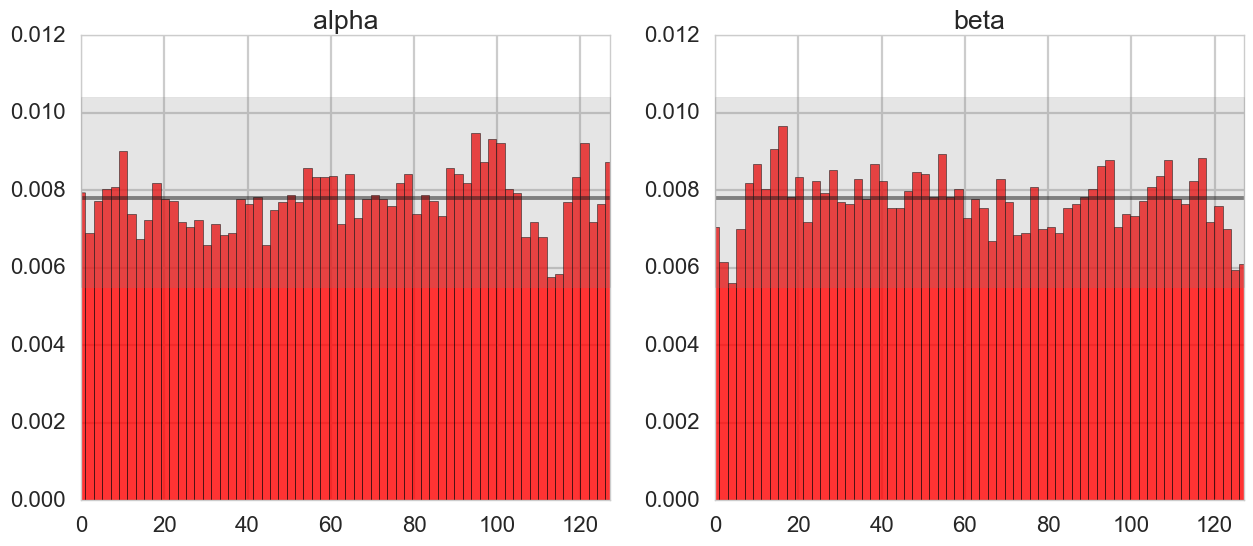

In [67]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
bins = (L+1)//2

end_points = stats.binom(n=N, p=1/(L+1)).interval(0.995)
median = stats.binom(n=N, p=1/(L+1), loc=0).median()

axes[0].hist(results_alpha, alpha=0.8, normed=True, color='r', bins=bins, range=[-1,L+1])
axes[1].hist(results_beta, alpha=0.8, normed=True, color='r', bins=bins, range=[-1,L+1])
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/N, alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/N, y2=end_points[1]/N, color='gray', alpha=0.2, zorder=100)
axes[1].axhline(y=median/N, alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/N, y2=end_points[1]/N, color='gray', alpha=0.2, zorder=100)

axes[0].set_xlim([0,L])
axes[1].set_xlim([0,L])

plt.show()

In [68]:
results_alphat, results_betat = algorithm(generate_data1, exp_tight_prior, ['alpha', 'beta']).values()

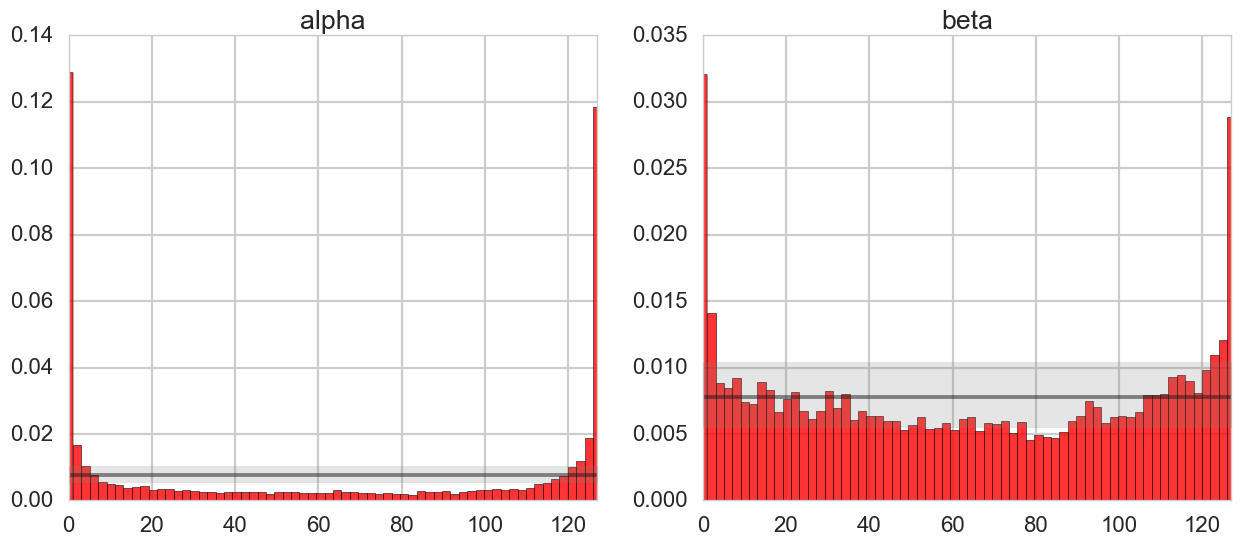

In [73]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
bins = (L+1)//2

end_points = stats.binom(n=N, p=1/(L+1)).interval(0.995)
median = stats.binom(n=N, p=1/(L+1), loc=0).median()

axes[0].hist(results_alphat, alpha=0.8, normed=True, color='r', bins=bins, range=[-1,L+1])
axes[1].hist(results_betat, alpha=0.8, normed=True, color='r', bins=bins, range=[-1,L+1])
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/N, alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/N, y2=end_points[1]/N, color='gray', alpha=0.2, zorder=100)
axes[1].axhline(y=median/N, alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/N, y2=end_points[1]/N, color='gray', alpha=0.2, zorder=100)

axes[0].set_xlim([0,L])
axes[1].set_xlim([0,L])

plt.show()

## Test Against Rubin, ... 

In [ ]:
plt.hist(range=[0,100])

## Test ADVI for this task

<hr />

<hr/>

# Experiment 2 - Gelman Schools

In [40]:
schools_code_cntrd = """
data {
    int<lower=0> J;            // number of schools
    real y[J];                 // estimated treatment effects
    real<lower=0> sigma[J];    // s.e. of effect estimates
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta[J];
}

model {
    mu ~ normal(0, 5);
    tau ~ normal(0, 5);
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

# schools_model_cntrd = pystan.StanModel(model_code=schools_code_cntrd)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4349ed348ee1f4965d0e0a229ab737e NOW.


In [41]:
schools_code_noncntrd = """
data {
    int<lower=0> J;
    real y[J];                
    real<lower=0> sigma[J];   
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ normal(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""
# schools_model_noncntrd = pystan.StanModel(model_code=schools_code_noncntrd)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f41e77eed58ee2e5f2071c46920d9e5 NOW.


In [42]:
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

In [43]:
fit_cntrd = schools_model_cntrd.sampling(data=schools_dat)
fit_noncntrd = schools_model_noncntrd.sampling(data=schools_dat)

In [45]:
fit_cntrd

Inference for Stan model: anon_model_a4349ed348ee1f4965d0e0a229ab737e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         4.41    0.16   3.31  -1.93   2.19    4.4   6.62  10.76    403    1.0
tau        3.76    0.13   2.34   0.88   1.93   3.25   5.03    9.4    344   1.02
theta[0]   6.14    0.21   5.57  -3.84   2.64   5.58   9.27  18.69    722    1.0
theta[1]   4.95    0.18   4.74  -4.14   1.91   4.79   7.92  14.61    711    1.0
theta[2]   3.98    0.19   5.24  -7.39   0.94   4.07   7.14  14.18    759    1.0
theta[3]   4.82     0.2   4.76  -4.43   1.86   4.68   7.74  14.33    578    1.0
theta[4]    3.6    0.17   4.49  -5.81   0.92   3.68    6.4   12.2    729    1.0
theta[5]   4.15    0.17   4.82   -6.2    1.2   4.22   7.14  13.45    761    1.0
theta[6]   6.25    0.19   4.93  -2.46   2.95   5.79   9.14  17.11    676   1.01
theta[7]   

In [46]:
fit_noncntrd

Inference for Stan model: anon_model_4f41e77eed58ee2e5f2071c46920d9e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.44    0.05    3.3  -2.19   2.28   4.42   6.57  10.92   4000    1.0
tau              3.31    0.05   2.55   0.14    1.3   2.76   4.83   9.28   3192    1.0
theta_tilde[0]    0.3    0.02    1.0  -1.69  -0.35    0.3   0.97   2.26   4000    1.0
theta_tilde[1]    0.1    0.02   0.96   -1.8  -0.54   0.09   0.75   1.95   4000    1.0
theta_tilde[2]  -0.07    0.02   0.97  -1.95  -0.74  -0.06   0.57   1.86   4000    1.0
theta_tilde[3]   0.06    0.02   0.96   -1.8  -0.58   0.05   0.72   1.99   4000    1.0
theta_tilde[4]  -0.13    0.01   0.94   -2.0  -0.77  -0.14   0.51   1.71   4000    1.0
theta_tilde[5]  -0.08    0.02   0.96  -1.98  -0.73  -0.09   0.58   1.82   4000    1.0
theta_tilde[6]   0.34    0.02   0.96 

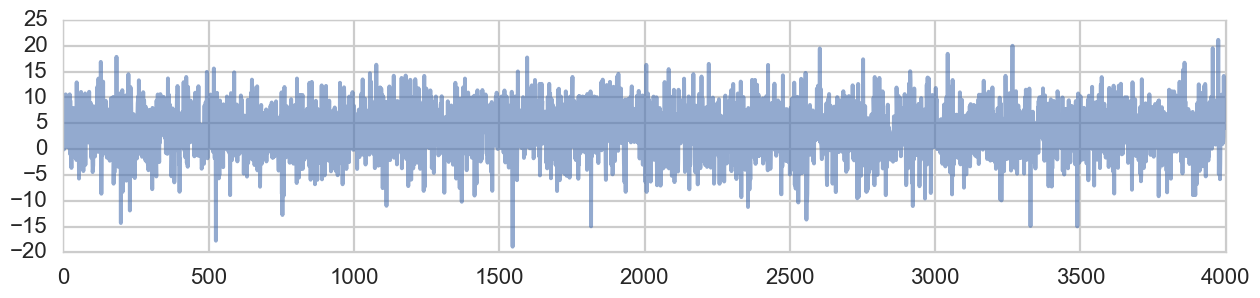

In [47]:
plt.figure(figsize=(15,3))
la = fit_cntrd.extract(permuted=True)
plt.plot(la['theta'][:,4], alpha=0.6)
plt.show()

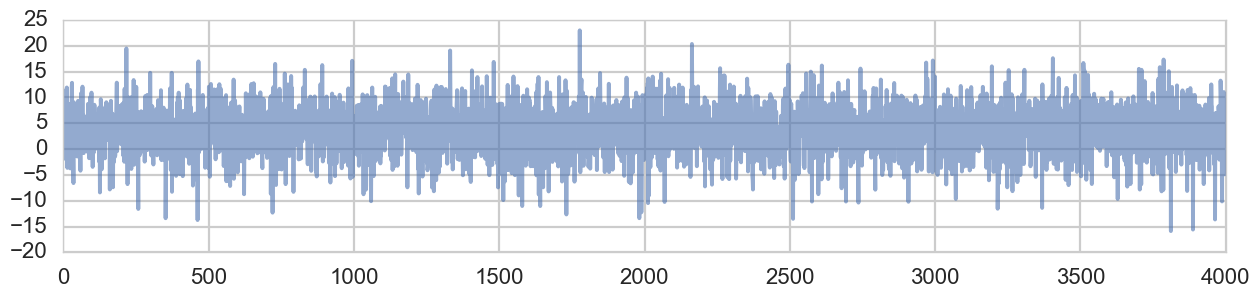

In [48]:
plt.figure(figsize=(15,3))
la = fit_noncntrd.extract(permuted=True)
plt.plot(la['theta'][:,4], alpha=0.6)
plt.show()

In [49]:
print("For the Centered Parameterization, count of divergences:", [np.sum(chain['divergent__']) for chain in fit_cntrd.get_sampler_params()])
print("For the Non-Centered Parameterization, count of divergences:", [np.sum(chain['divergent__']) for chain in fit_noncntrd.get_sampler_params()])

For the Centered Parameterization, count of divergences: [112.0, 187.0, 81.0, 96.0]
For the Non-Centered Parameterization, count of divergences: [14.0, 16.0, 21.0, 14.0]


In [52]:
get_last_sample(la)

{'mu': 3.4860288645334716,
 'tau': 3.480699136881204,
 'theta': array([ 0.86358052, -2.23514782,  4.25194494,  7.10168981,  3.89097049,
         4.34455898,  5.71959137,  1.57470599]),
 'theta_tilde': array([-0.75342575, -1.64368607,  0.22004662,  1.03877434,  0.11633916,
         0.2466545 ,  0.64169939, -0.54912039])}

In [55]:
np.concatenate([la.get('mu'), la.get('mu')]).shape

(8000,)

In [ ]:
 schools_model_noncntrd.sampling(data=schools_dat, )

### Define the data generative model:

In [317]:
def generate_schools_cntrd():
    sigma = [15, 10, 16, 11,  9, 11, 10, 18]
    
    mu = np.random.normal(0, 5)
    tau = np.abs(np.random.normal(0, 5))
    theta = np.random.normal(mu, tau, size=len(sigma))
    
    Y = []
    for i, sig in enumerate(sigma):
        Y.append(np.random.normal(theta[i], sig))

    return {'J': 8, 'sigma': sigma, 'y': Y, 'tau': tau, 'mu': mu, 'theta': theta}

def generate_schools_noncntrd():
    sigma = [15, 10, 16, 11,  9, 11, 10, 18]
    
    mu = np.random.normal(0, 5)
    tau = np.abs(np.random.normal(0, 5))
    theta_tilda = np.random.normal(0, 1, size=len(sigma))
    theta = mu + tau*theta_tilda
    
    Y = []
    for i, sig in enumerate(sigma):
        Y.append(np.random.normal(theta[i], sigma[i]))

    return {'J': 8, 'sigma': sigma, 'y': Y, 'tau': tau, 'mu': mu, 'theta': theta}

In [318]:
cntrd_results = algorithm1(
                    generate_schools_cntrd,
                    schools_model_cntrd,
                    ['mu', 'tau', 'theta']
                  )

In [319]:
noncntrd_results = algorithm1(
                    generate_schools_noncntrd,
                    schools_model_noncntrd,
                    ['mu', 'tau', 'theta']
                  )

In [323]:
var = ['tau', 'theta']
mu, tau, theta = cntrd_results.values()

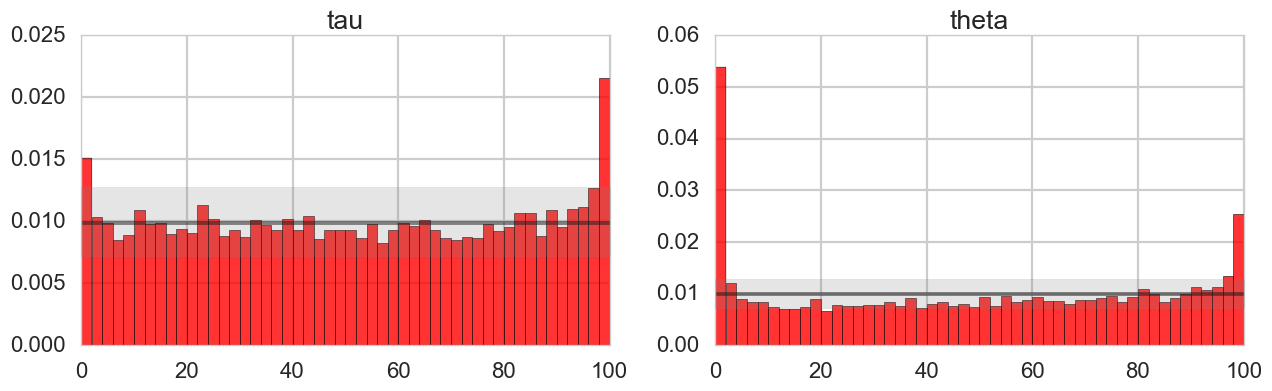

In [324]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

L = 100
end_points = stats.binom(n=N, p=1/(L+1)).interval(0.995)
median = stats.binom(n=N, p=1/(L+1), loc=0).median()

axes[0].hist(tau, alpha=0.8, normed=True, color='r', bins=bins)
axes[1].hist(theta, alpha=0.8, normed=True, color='r', bins=bins)

for i,ax in enumerate(axes):
    ax.axhline(y=median/N, alpha=0.5, color='black')
    ax.fill_between(x=np.arange(0,L+1), y1=end_points[0]/N, y2=end_points[1]/N, color='gray', alpha=0.2, zorder=100)
    ax.set_title(var[i])
    
plt.show()

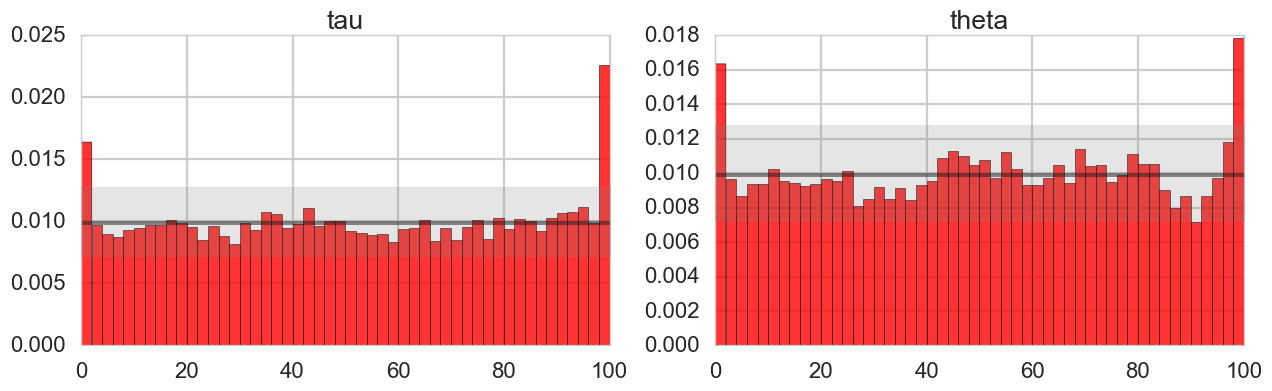

In [325]:
mu, tau, theta = noncntrd_results.values()

fig, axes = plt.subplots(1,2,figsize=(15,4))

L = 100
end_points = stats.binom(n=N, p=1/(L+1)).interval(0.995)
median = stats.binom(n=N, p=1/(L+1), loc=0).median()

axes[0].hist(tau, alpha=0.8, normed=True, color='r', bins=bins)
axes[1].hist(theta, alpha=0.8, normed=True, color='r', bins=bins)

for i,ax in enumerate(axes):
    ax.axhline(y=median/N, alpha=0.5, color='black')
    ax.fill_between(x=np.arange(0,L+1), y1=end_points[0]/N, y2=end_points[1]/N, color='gray', alpha=0.2, zorder=100)
    ax.set_title(var[i])
    
plt.show()